In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose,BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LeakyReLU

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [5]:
path = 'mitbih_database'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
# Read files
records = list()
annotations = list()

In [7]:
files = os.listdir(path)
for f in files:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path +'/'+filename + file_extension)

    # *.txt
    else:
        annotations.append(path +'/'+ filename + file_extension)

In [8]:
print(annotations)
print(len(records))

['mitbih_database/100annotations.txt', 'mitbih_database/101annotations.txt', 'mitbih_database/102annotations.txt', 'mitbih_database/103annotations.txt', 'mitbih_database/104annotations.txt', 'mitbih_database/105annotations.txt', 'mitbih_database/106annotations.txt']
7


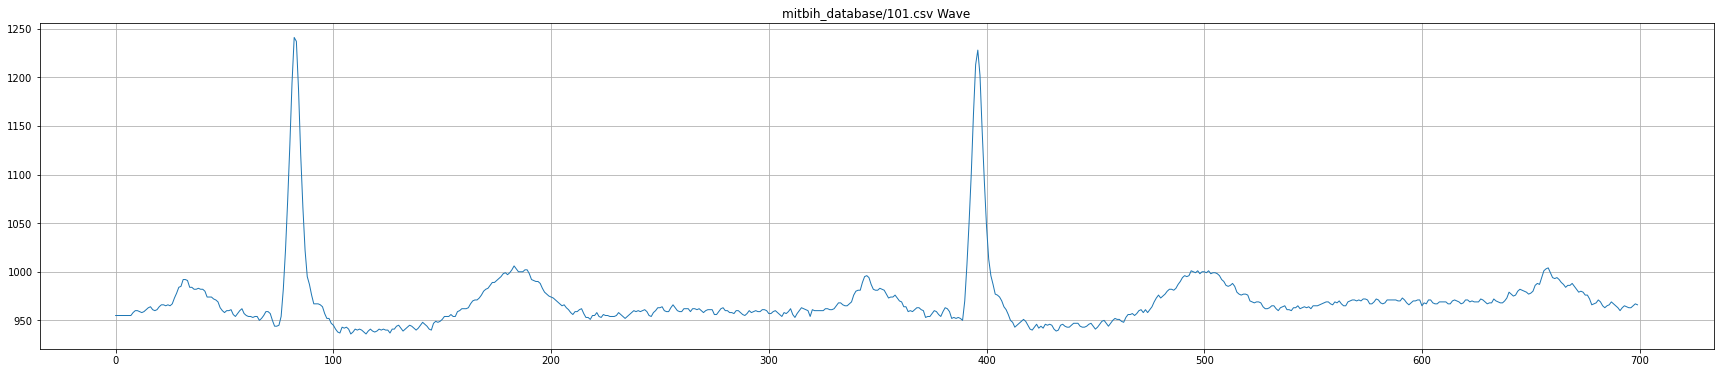

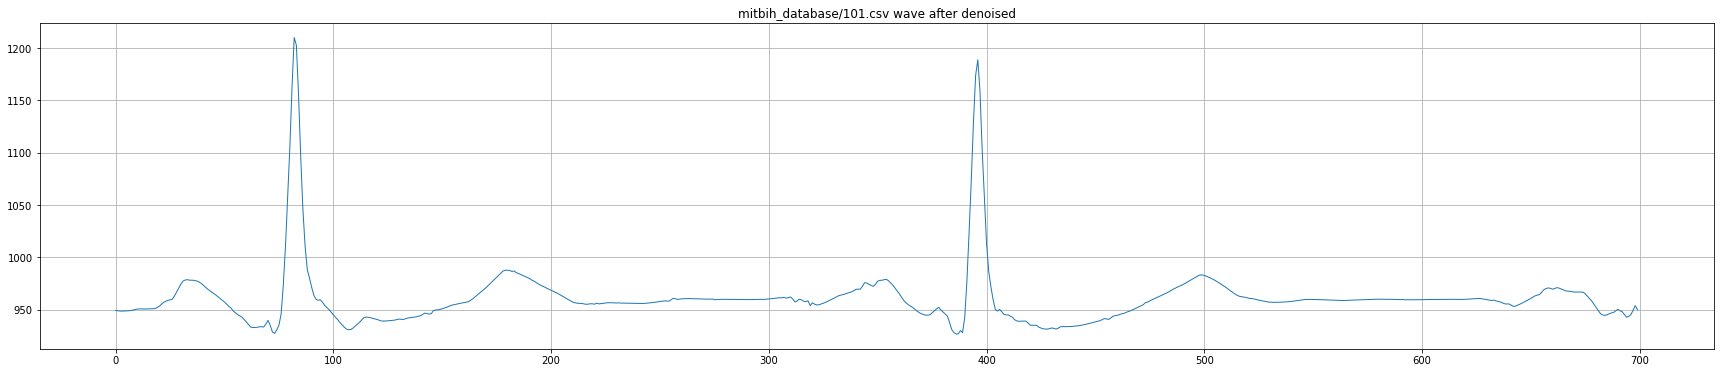

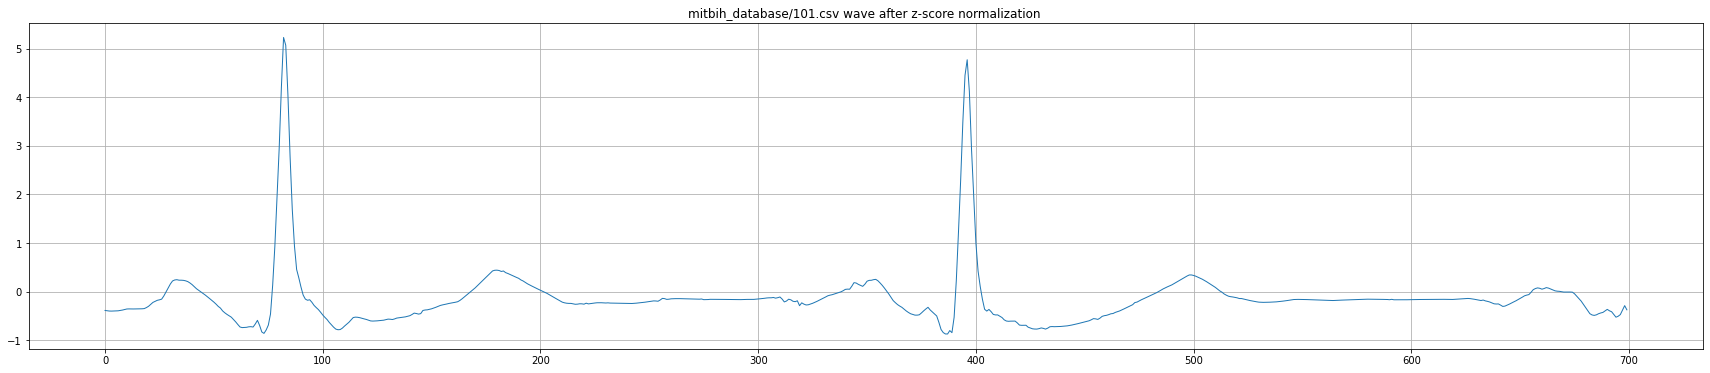

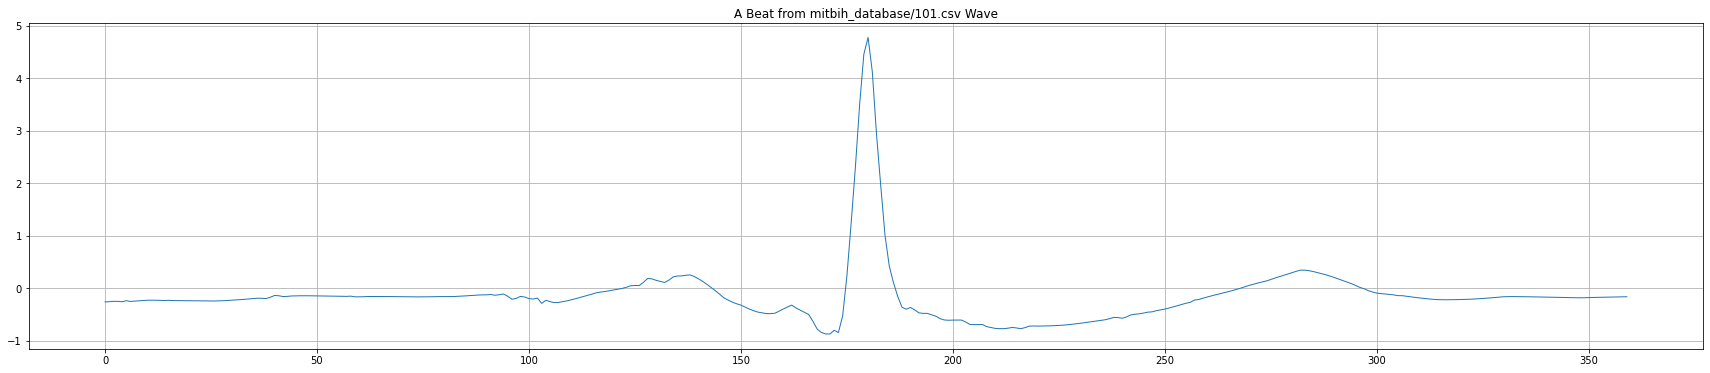

(11078, 360) (11078,)


In [9]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as c:
        spamreader = csv.reader(c, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [10]:
# data = X[0]
# plt.plot(data)
# plt.show()

for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
# #         X[i].append(y[i])
print(np.shape(X))

(11078, 361)


In [12]:
# # class_distribution
# X_train_df = pd.DataFrame(X)
# per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
# print(per_class)
# plt.figure(figsize=(20,10))
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()

In [14]:
# # #rebalancing classes
# df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
# df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
# df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
# df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# # df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
# df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

# df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
# df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
# df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
# df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# # df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# # X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [16]:
# per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
# print(per_class)
# plt.figure(figsize=(20,10))
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()

In [17]:
train, test = train_test_split(X_train_df, test_size=0.20)
# train = np.array(train)
# test = np.array(test)
# data = train[0]
# plt.plot(data)
# plt.show()
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (8862, 361)
X_test  :  (2216, 361)


In [18]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=tf.keras.utils.to_categorical(target_train)
test_y=tf.keras.utils.to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(8862, 5) (2216, 5)


In [19]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(8862, 360, 1) (2216, 360, 1)


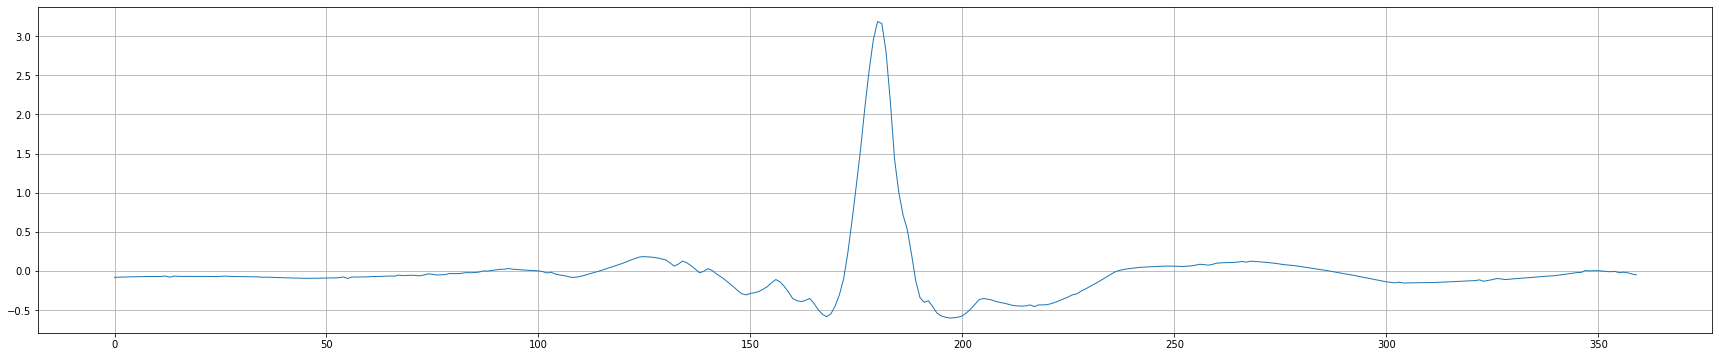

(8862, 360, 1)


In [20]:
train = np.array(train_x)
data = train[1]
plt.plot(data)
plt.show()
print(train_x.shape)

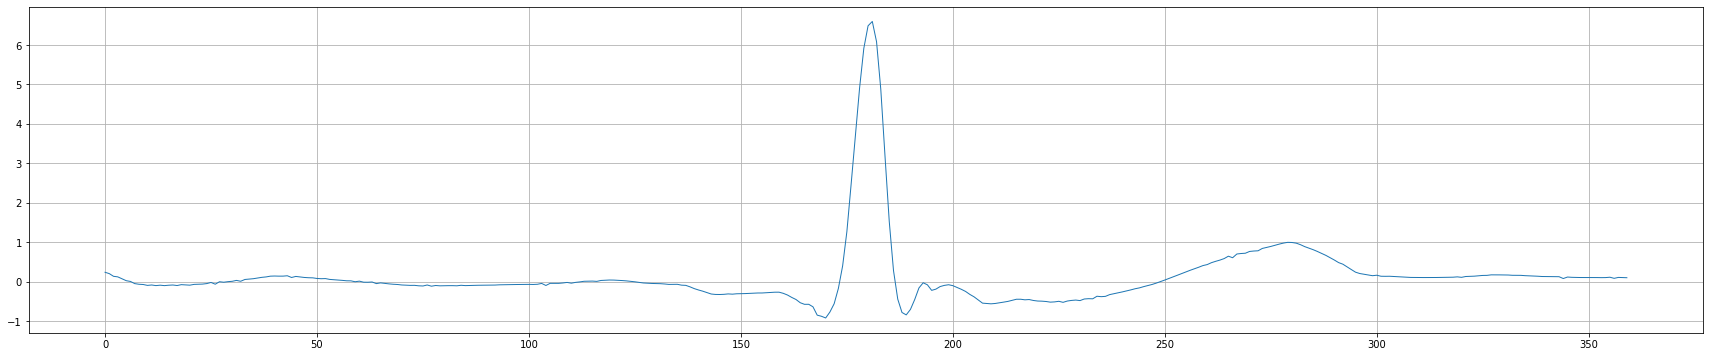

In [21]:
# print(test_x)
test = np.array(test_x)
data = test[0]
plt.plot(data)
plt.show()

In [22]:
data = pd.read_csv('./mitbih_database/102.csv')
data.head()

,'sample #','V5','V2'
0,0,984,1025
1,1,984,1025
2,2,984,1025
3,3,984,1025
4,4,984,1025


# Build The Convolutional Autoencoders

In [23]:
#encoder part
input_layer = Input(shape=(360,1 ), name="INPUT")
x = Conv1D(8,3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(2, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2,padding='valid')(x)
x = Conv1D(2, 3, activation='relu', padding='same')(x)
code_layer = MaxPooling1D(2, name="CODE")(x) #encoded signal

In [24]:
#decoder part
x = Conv1D(4,2, activation='relu')(code_layer)
x = UpSampling1D(2)(x)
x = Conv1D(4,3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(4,1, activation='relu')(x)
x = Conv1D(8,3, activation='relu', padding='same')(x)
x = UpSampling1D(3)(x)
x = Conv1D(1,3,padding='same')(x)
x = UpSampling1D(3)(x)
output_layer = Conv1D(1, 3, padding='same', name="OUTPUT")(x)

In [25]:
ae_model = Model(input_layer,output_layer)
ae_model.compile(optimizer='adam',loss='mse')
ae_model.summary()
ae_model.output_shape

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 360, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 360, 8)            32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 180, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 180, 4)            100       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 90, 4)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 4)             52        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 4)            

(None, 360, 1)

In [ ]:
history = ae_model.fit(train_x, train_x,epochs=500,batch_size=36,shuffle=True,validation_data=(test_x, test_x))

Epoch 1/500
247/247 [==============================] - 15s 62ms/step - loss: 0.7709 - val_loss: 0.5656
Epoch 2/500
247/247 [==============================] - 14s 55ms/step - loss: 0.3378 - val_loss: 0.1995
Epoch 3/500
247/247 [==============================] - 14s 58ms/step - loss: 0.1926 - val_loss: 0.1694
Epoch 4/500
247/247 [==============================] - 14s 58ms/step - loss: 0.1715 - val_loss: 0.1559
Epoch 5/500
247/247 [==============================] - 15s 59ms/step - loss: 0.1566 - val_loss: 0.1401
Epoch 6/500
247/247 [==============================] - 4s 17ms/step - loss: 0.1425 - val_loss: 0.1304
Epoch 7/500
247/247 [==============================] - 4s 16ms/step - loss: 0.1335 - val_loss: 0.1248
Epoch 8/500
247/247 [==============================] - 3s 14ms/step - loss: 0.1279 - val_loss: 0.1210
Epoch 9/500
247/247 [==============================] - 3s 14ms/step - loss: 0.1231 - val_loss: 0.1150
Epoch 10/500
247/247 [==============================] - 3s 14ms/step - loss: 

In [24]:
ae_model.save("Auto_encoder_model.h5")

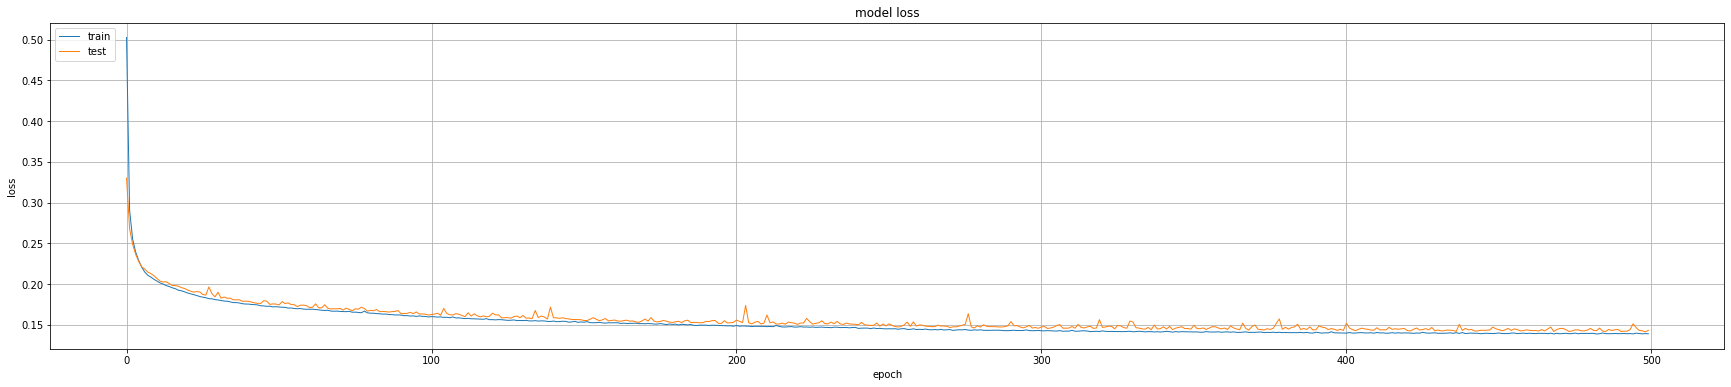

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
get_encoded_beat = Model(inputs=ae_model.input, outputs=ae_model.get_layer("CODE").output)
print(len(test_x))

5000


In [27]:
encoded_beat = get_encoded_beat.predict(test_x)
encoded_beat = encoded_beat.reshape((len(test_x),22))
encoded_beat.shape

(5000, 22)

In [28]:
reconstructed_beats = ae_model.predict(test_x)

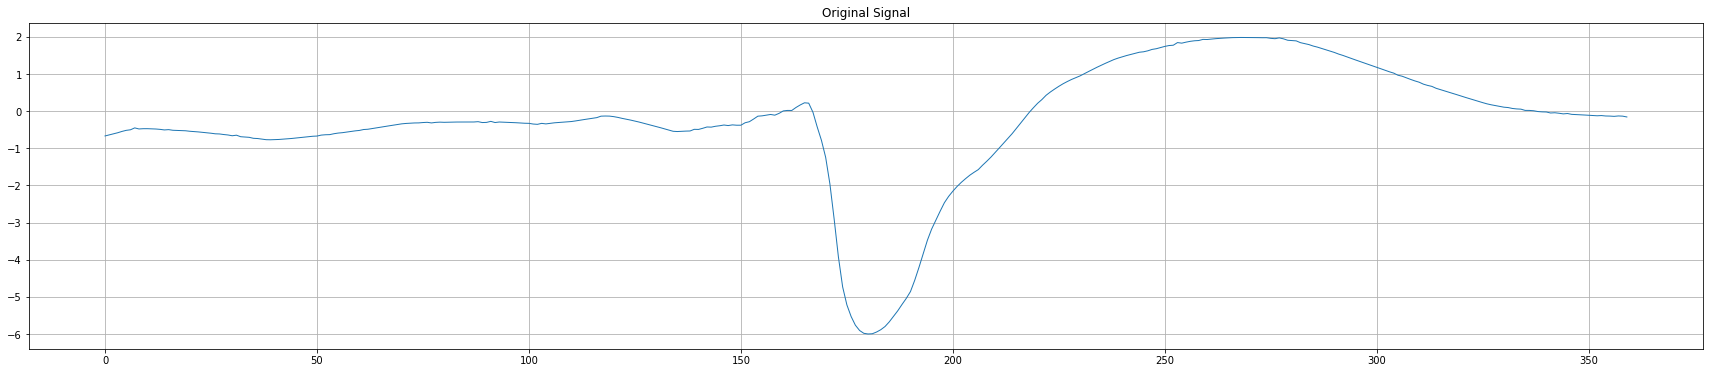

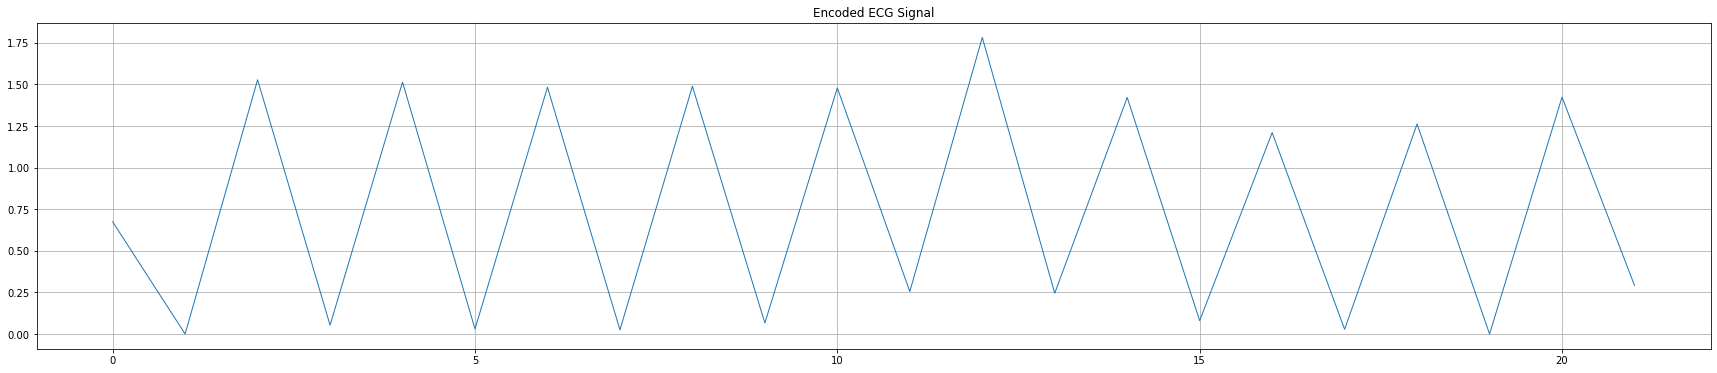

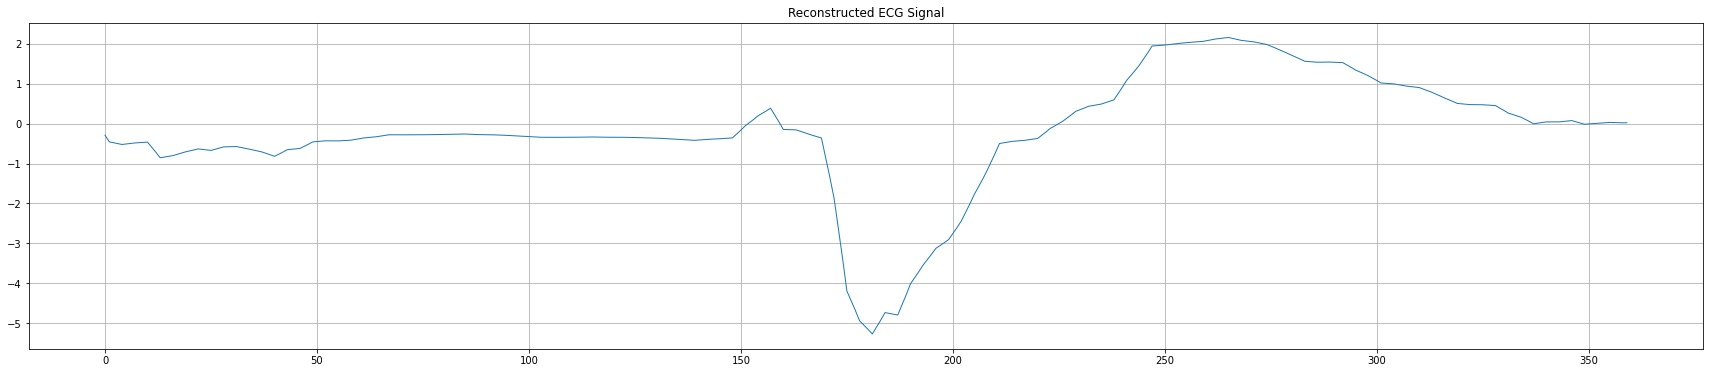

In [45]:
#original beats
test_beat = np.array(test_x)
data = test_beat[1000]
plt.plot(data)
plt.title("Original Signal")
plt.show()

#encoded beats
enc_beats = np.array(encoded_beat)
data1 = enc_beats[1000]
plt.plot(data1)
plt.title("Encoded ECG Signal")
plt.show()

#reconstructed beats
rec_beats = np.array(reconstructed_beats)
data2 = rec_beats[1000]
plt.plot(data2)
plt.title("Reconstructed ECG Signal")
plt.show()

In [30]:
#Compression ratio
x = np.array(test_x)
original_file_size = x.size*x.itemsize

z = np.array(encoded_beat)
print(x.itemsize,z.itemsize)
print(x.size, z.size)
encoded_file_size = z.size*z.itemsize

8 4
1800000 110000


In [31]:
y = np.array(reconstructed_beats)
reconstructed_file_size = y.size*y.itemsize

In [32]:
cr = original_file_size/encoded_file_size

In [33]:
print(cr)

32.72727272727273


In [34]:
print(test_x)

[[[ 1.36755878]
  [ 1.39518047]
  [ 1.3876474 ]
  ...
  [-0.72412712]
  [-0.65465685]
  [-0.63448093]]

 [[-0.65591703]
  [-0.63849376]
  [-0.61833918]
  ...
  [-0.08210165]
  [-0.09531533]
  [-0.10891926]]

 [[ 1.19964986]
  [ 1.47120515]
  [ 1.77253809]
  ...
  [ 0.09768959]
  [ 0.09411208]
  [ 0.0893412 ]]

 ...

 [[-0.22892227]
  [-0.21988117]
  [-0.20651999]
  ...
  [-0.1982217 ]
  [-0.19089838]
  [-0.18393526]]

 [[-1.42987172]
  [-1.2664679 ]
  [-1.09412981]
  ...
  [-0.61472192]
  [-0.61391893]
  [-0.62732264]]

 [[-0.15148425]
  [-0.20036599]
  [-0.19181143]
  ...
  [ 0.20110985]
  [ 0.19204181]
  [ 0.20675576]]]


In [35]:
print(reconstructed_beats)

[[[ 0.6313121 ]
  [ 0.9563142 ]
  [ 1.0432035 ]
  ...
  [-0.5095786 ]
  [-0.40948367]
  [-0.26859775]]

 [[-0.47477296]
  [-0.7414809 ]
  [-0.83782065]
  ...
  [-0.05975264]
  [-0.04912815]
  [-0.02541905]]

 [[ 1.1393481 ]
  [ 1.7361287 ]
  [ 2.031836  ]
  ...
  [ 0.10322101]
  [ 0.08370669]
  [ 0.06422188]]

 ...

 [[-0.09182675]
  [-0.15367416]
  [-0.16181521]
  ...
  [-0.07349506]
  [-0.05862305]
  [-0.03182649]]

 [[-0.47451568]
  [-0.741086  ]
  [-0.7951886 ]
  ...
  [-0.59643847]
  [-0.48875287]
  [-0.32209098]]

 [[-0.08257639]
  [-0.13947523]
  [-0.14195801]
  ...
  [ 0.22782543]
  [ 0.18297346]
  [ 0.13121007]]]


In [36]:
def calculate_PRD(orig_sig, reconstructed_sig):
    
    #Define a function to calculate the percentage root-mean-square difference (PRD)
    
    num = np.sum((orig_sig - reconstructed_sig)**2)
    den = np.sum(orig_sig**2)

    PRD = np.sqrt(num/den)

    return PRD

In [51]:
prd = calculate_PRD(test_x,reconstructed_beats)
print("PRD",calculate_PRD(test_x,reconstructed_beats))

PRD 0.35105696155574584


In [38]:
from numpy import asarray
from numpy import save
# define data
data = asarray(test_x)
# save to npy file
save('data.npy', data)

In [39]:
from numpy import asarray
from numpy import save
# define data
data = asarray(reconstructed_beats)
# save to npy file
save('recon_data.npy', data)

In [40]:
from numpy import asarray
from numpy import save
# define data
data = asarray(encoded_beat)
# save to npy file
save('encoded_data.npy', data)

Original signal:  0


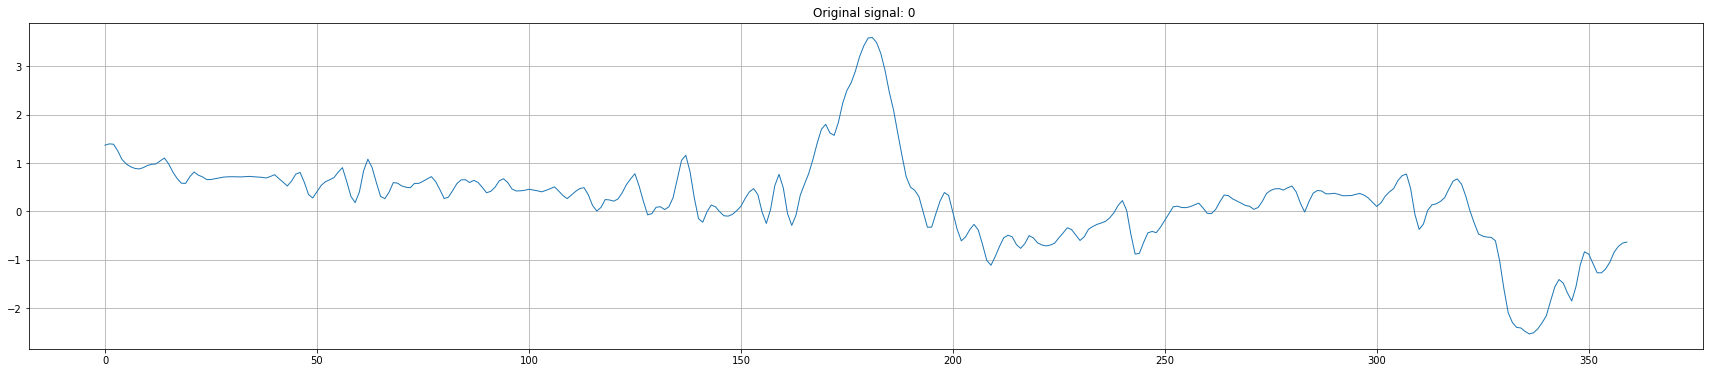

Encoded signal:  0


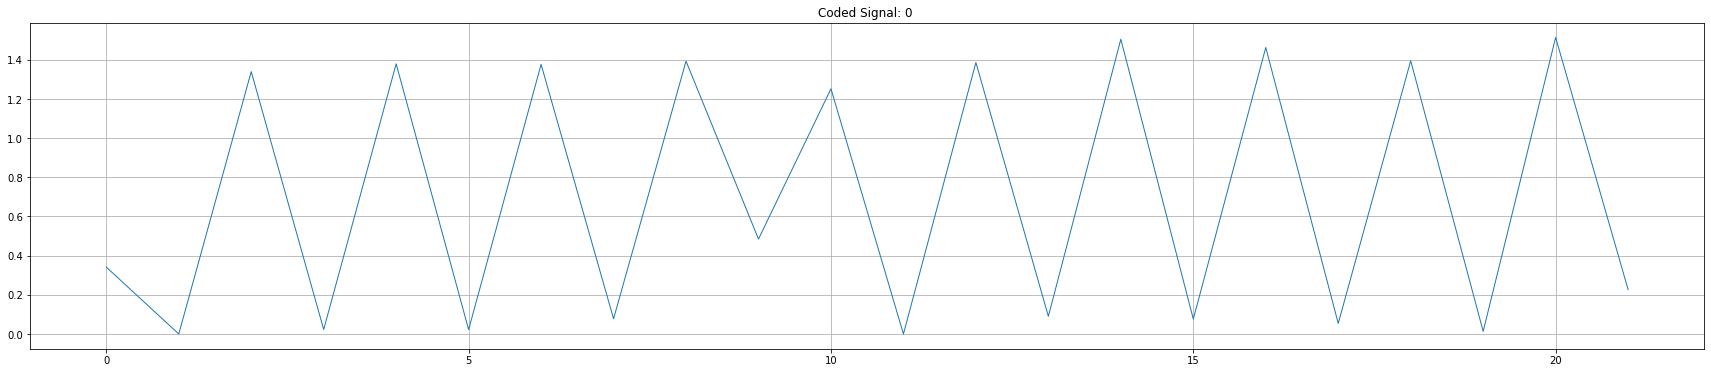

Reconstructed signal:  0


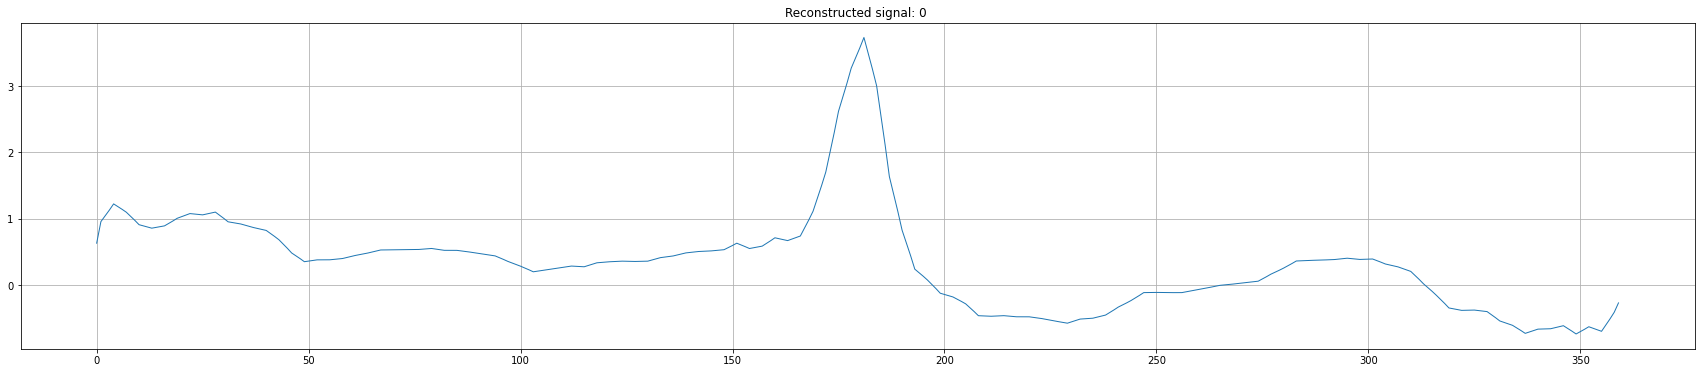

Original signal:  1


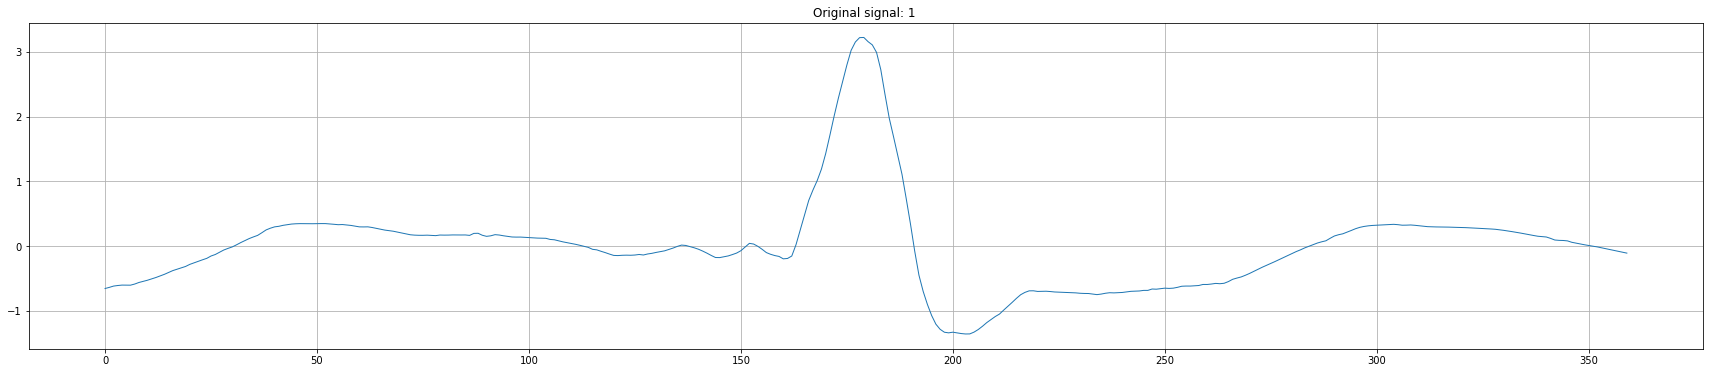

Encoded signal:  1


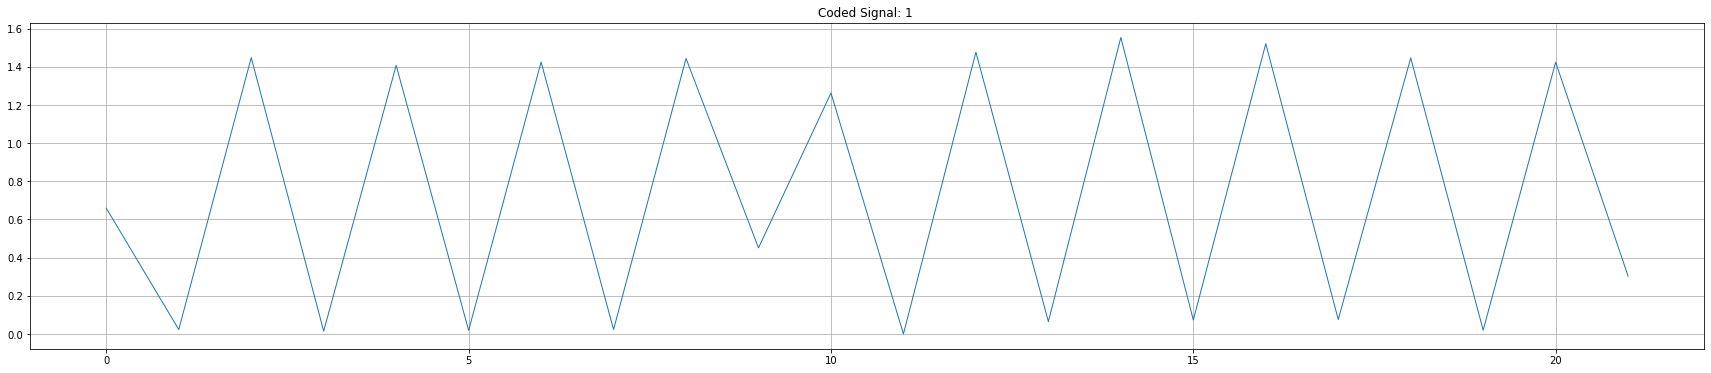

Reconstructed signal:  1


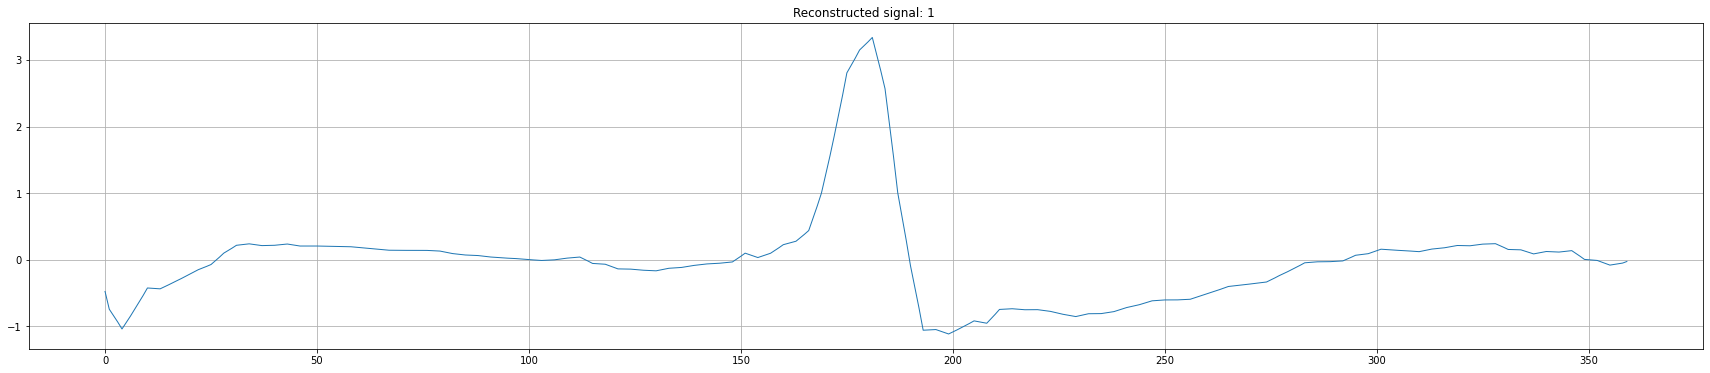

Original signal:  2


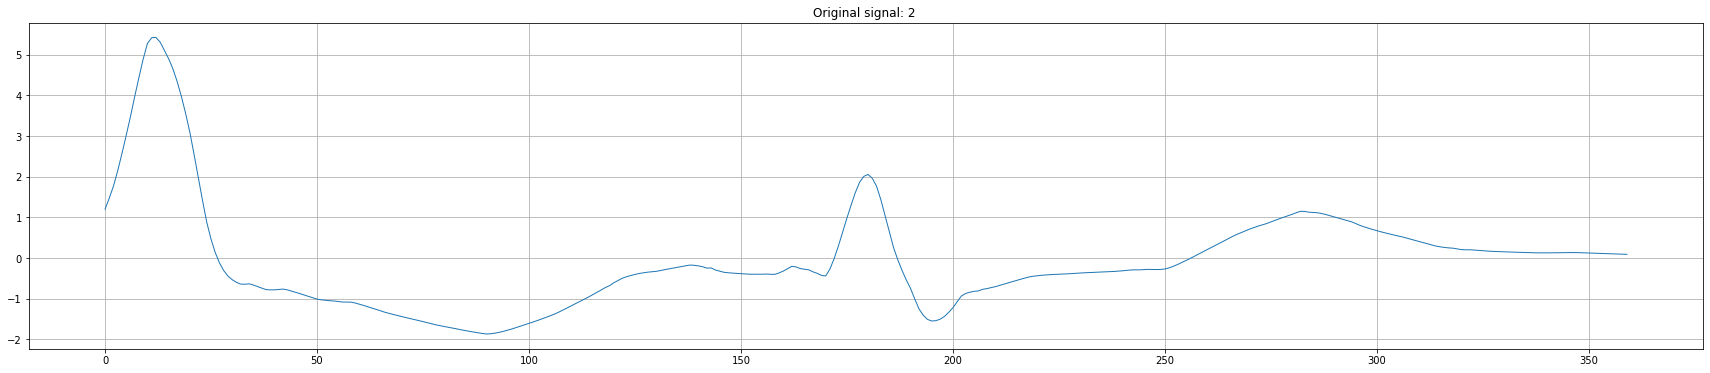

Encoded signal:  2


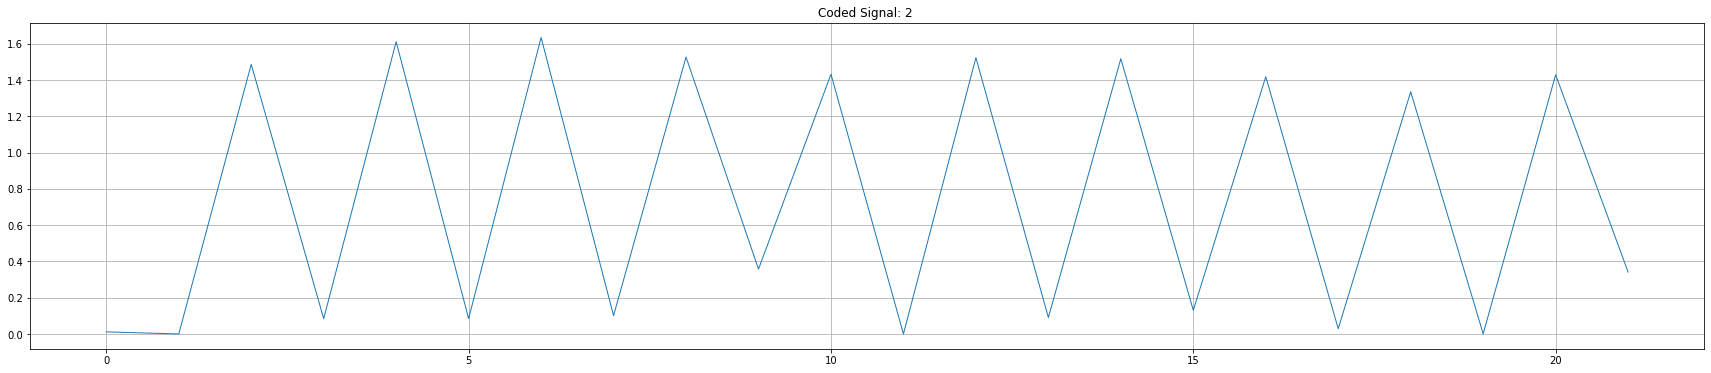

Reconstructed signal:  2


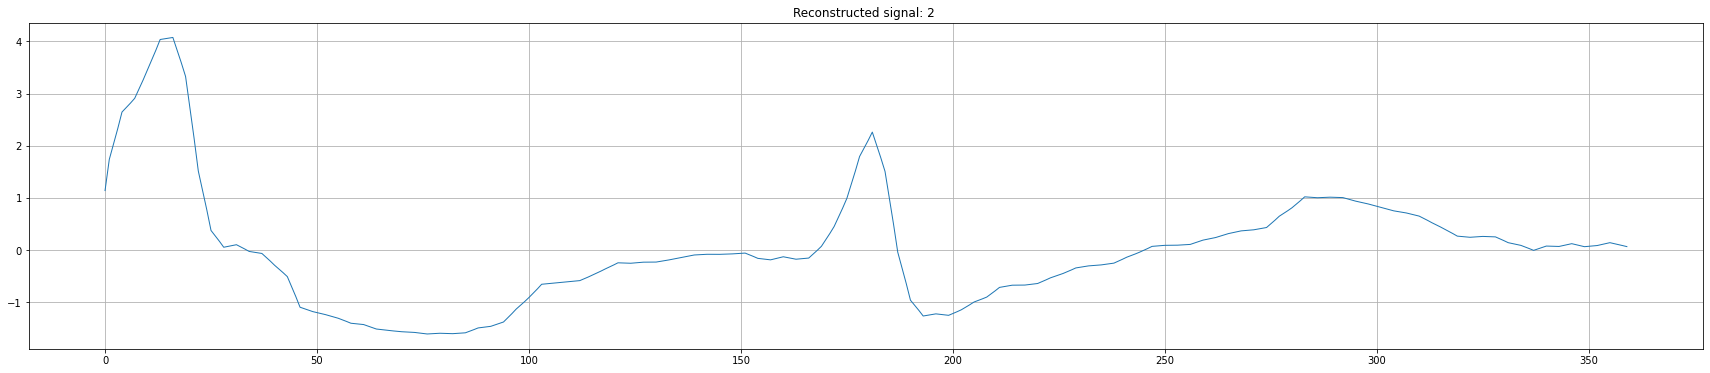

Original signal:  3


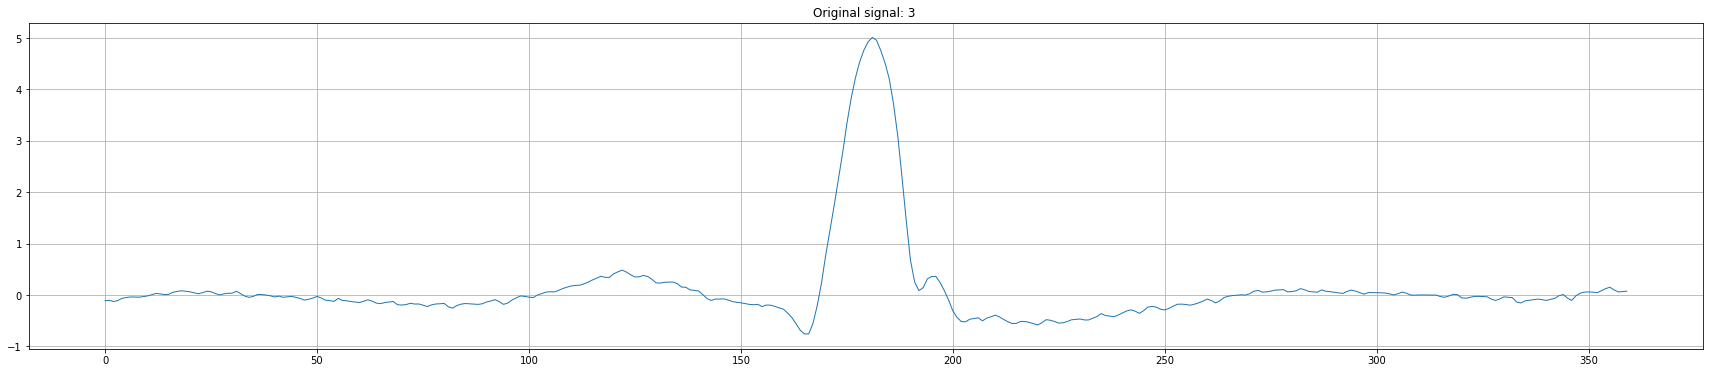

Encoded signal:  3


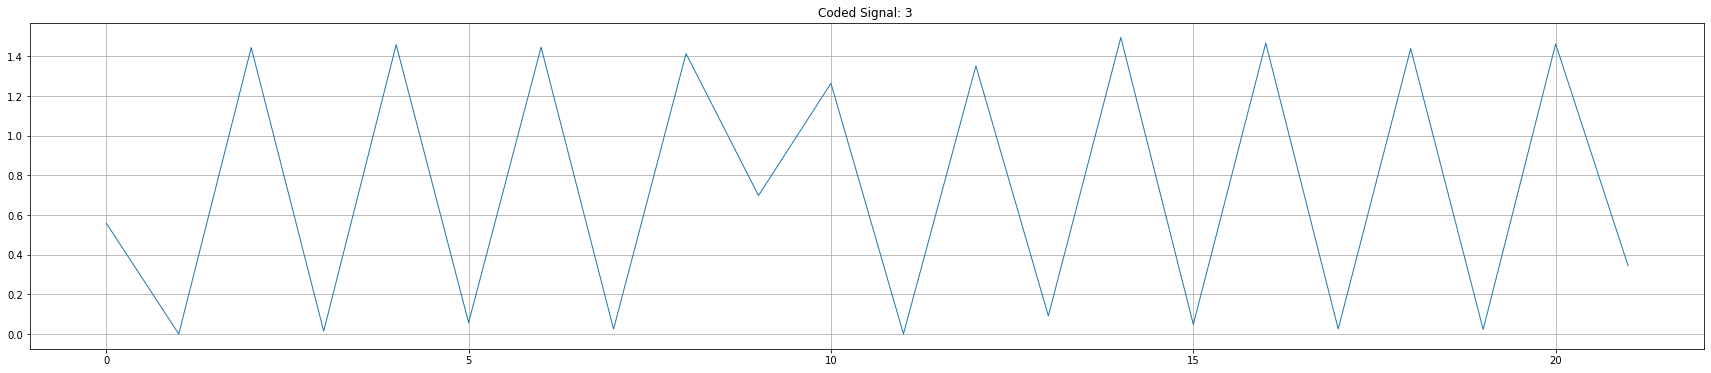

Reconstructed signal:  3


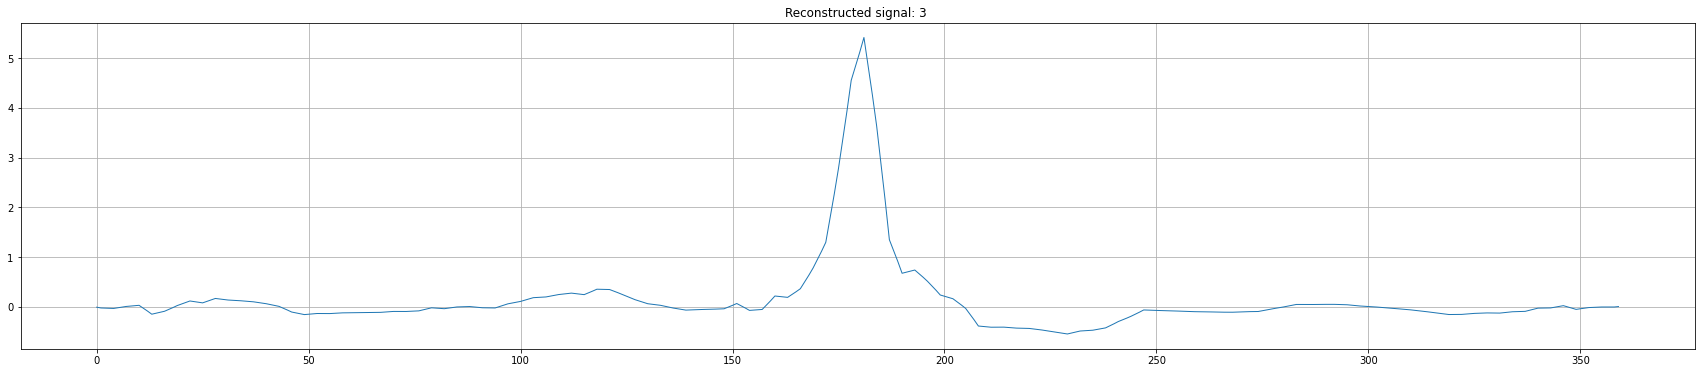

Original signal:  4


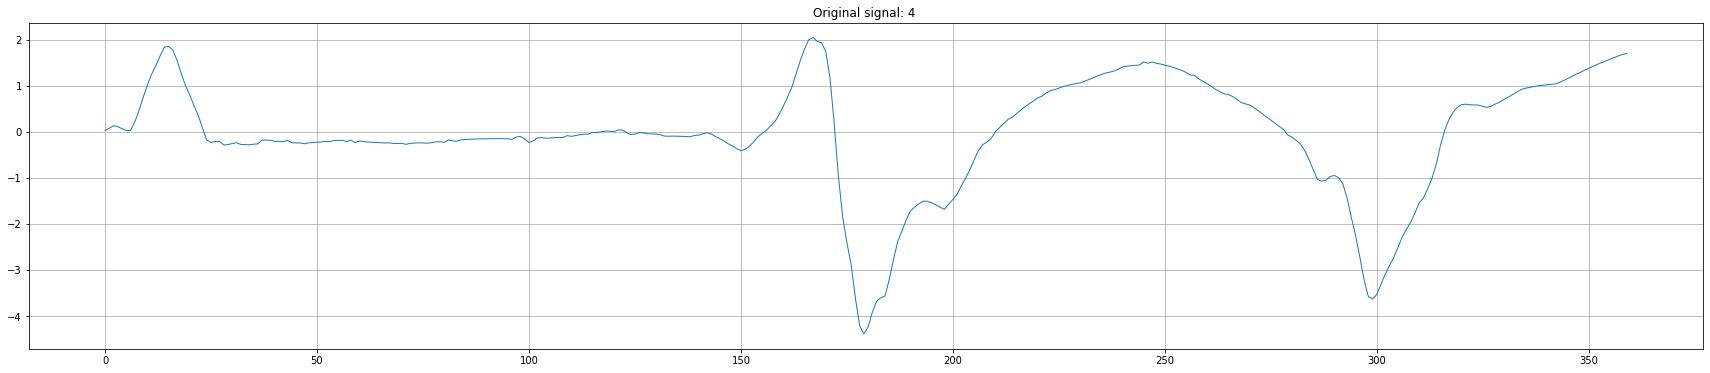

Encoded signal:  4


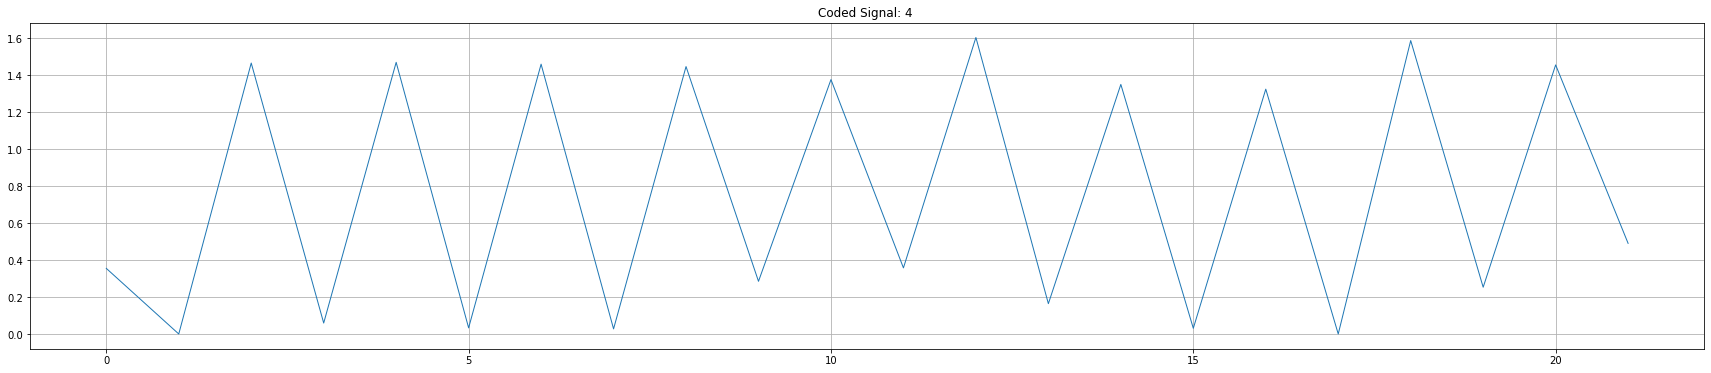

Reconstructed signal:  4


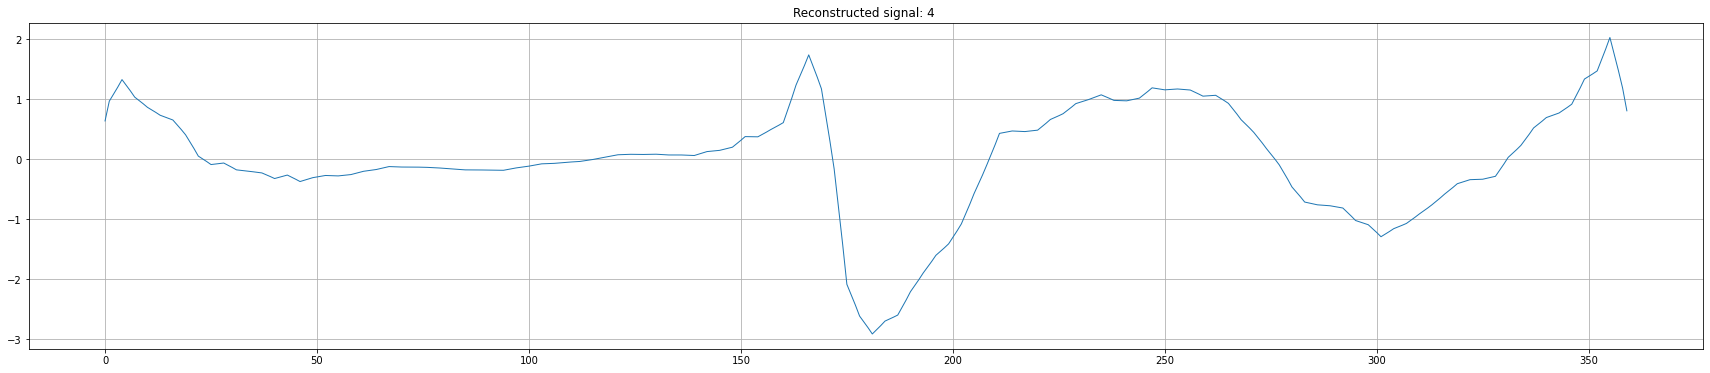

Original signal:  5


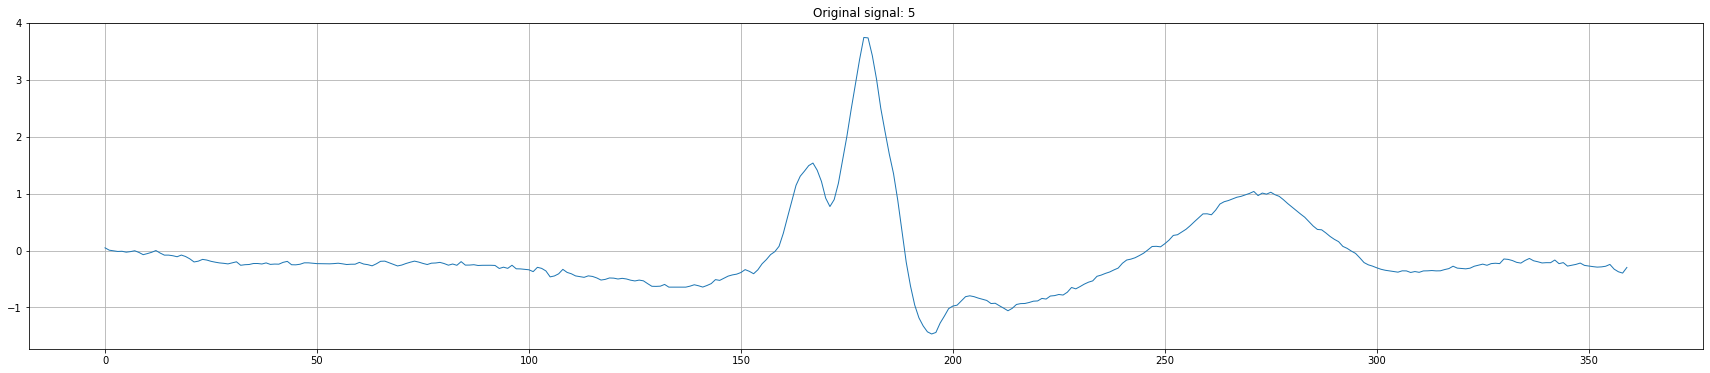

Encoded signal:  5


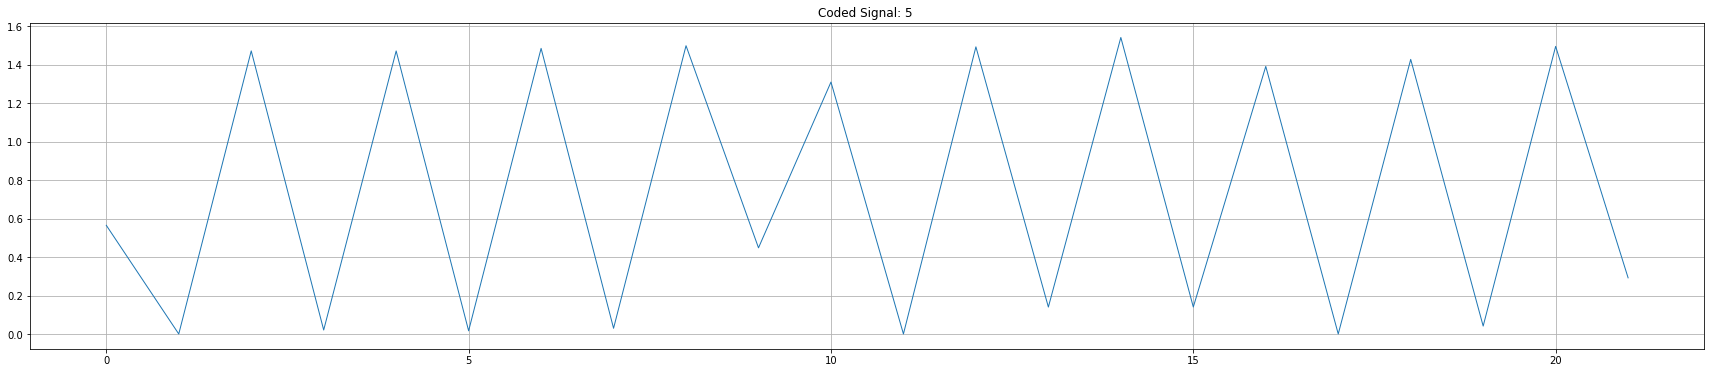

Reconstructed signal:  5


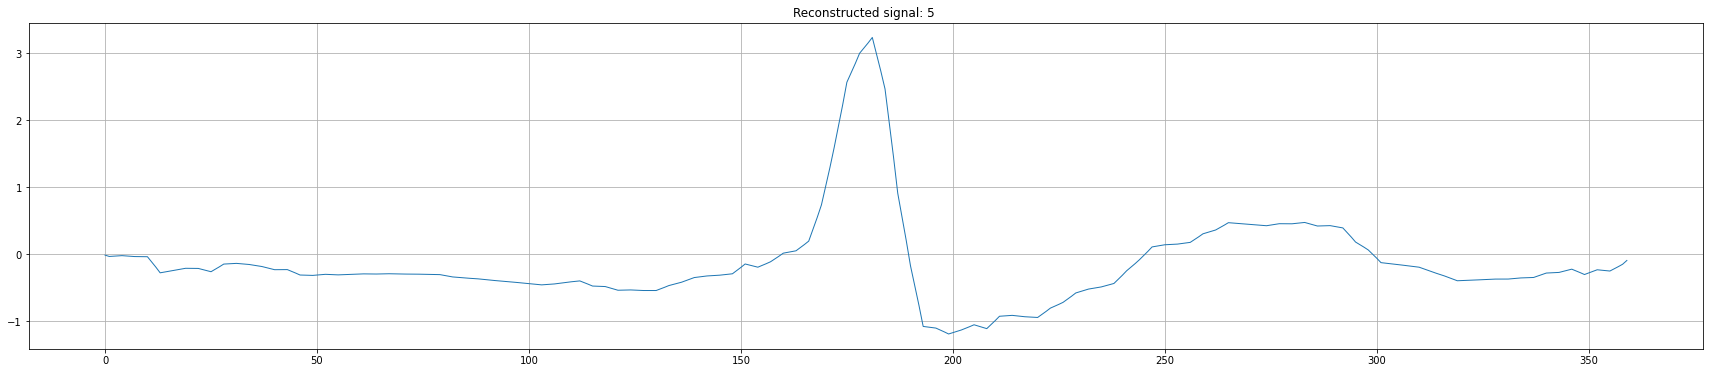

Original signal:  6


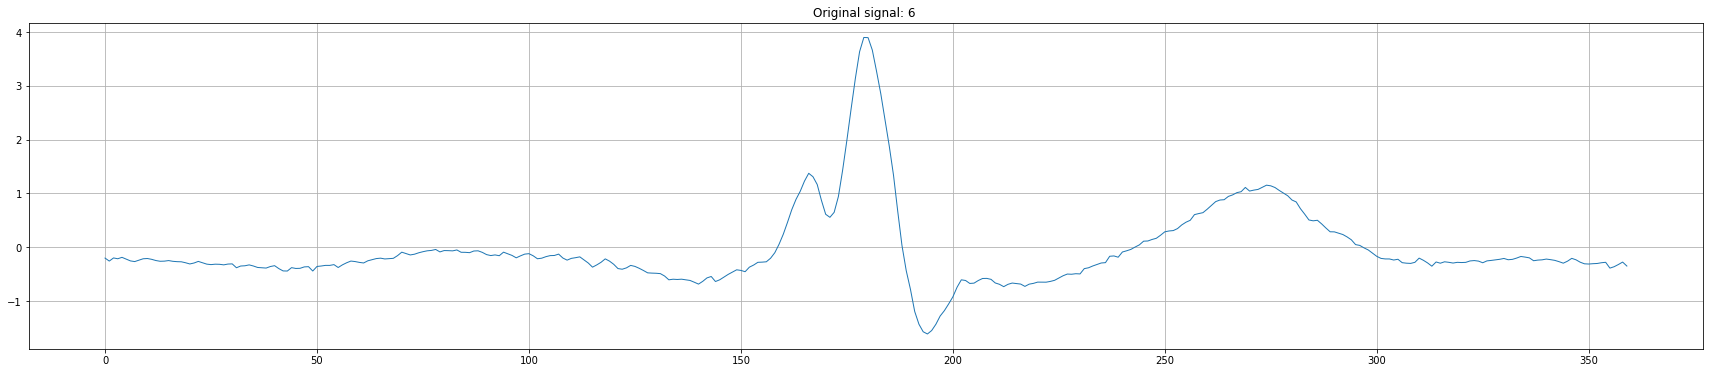

Encoded signal:  6


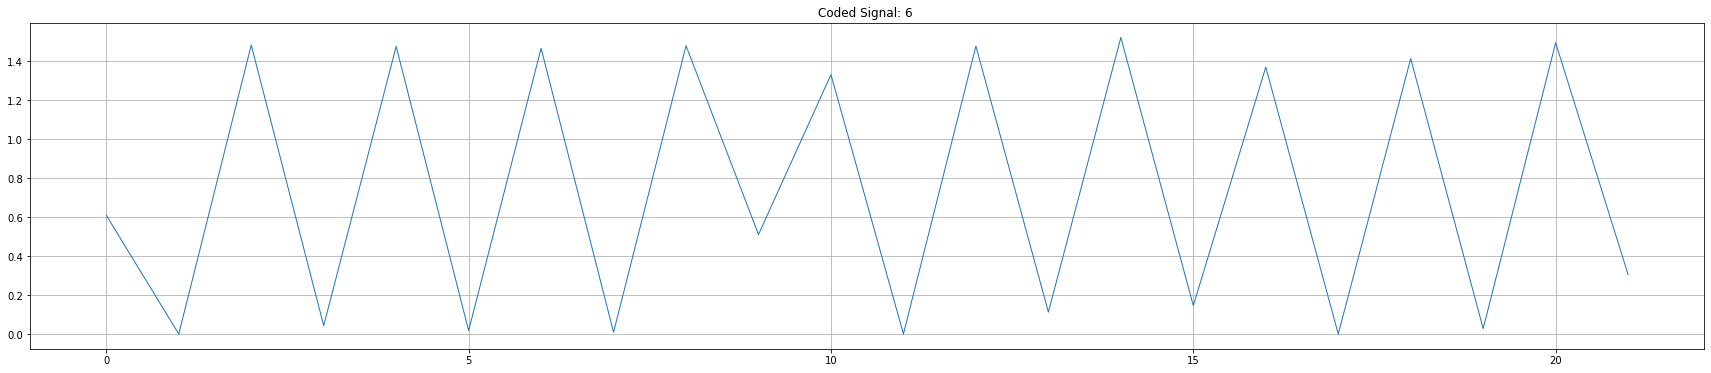

Reconstructed signal:  6


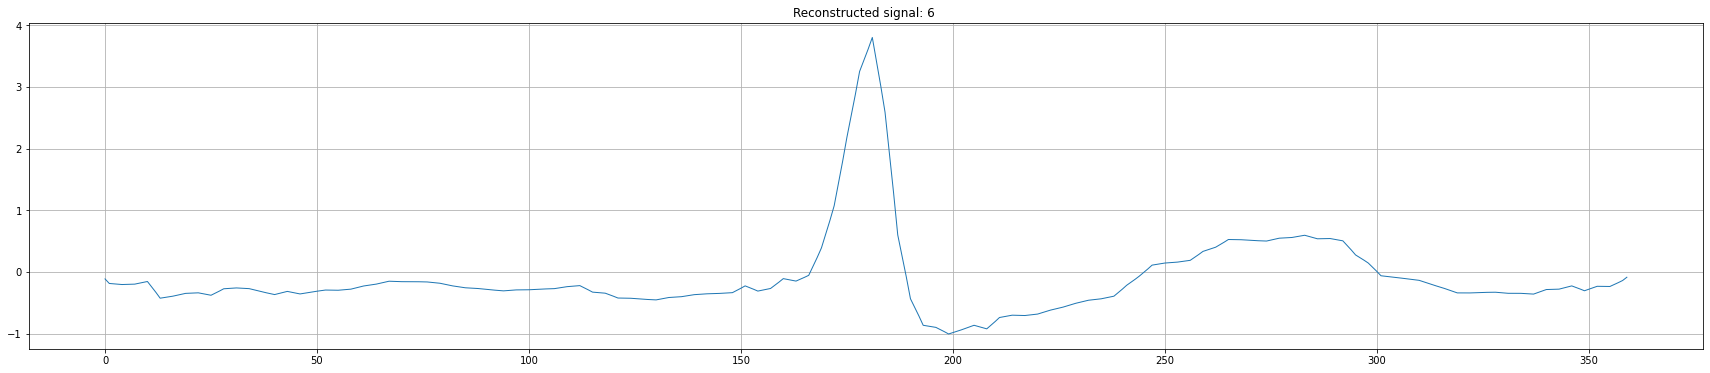

Original signal:  7


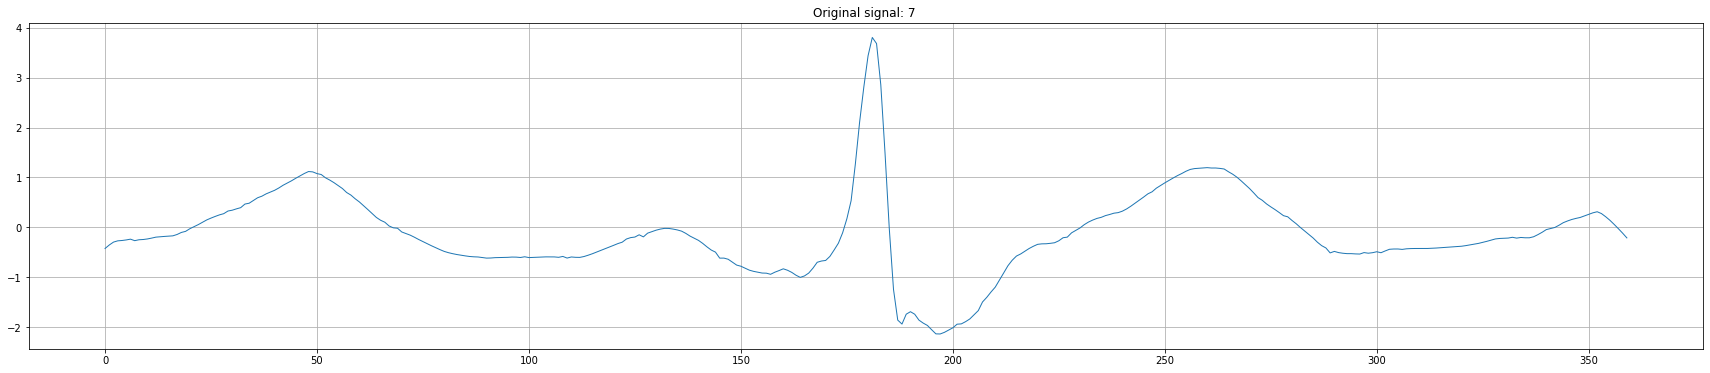

Encoded signal:  7


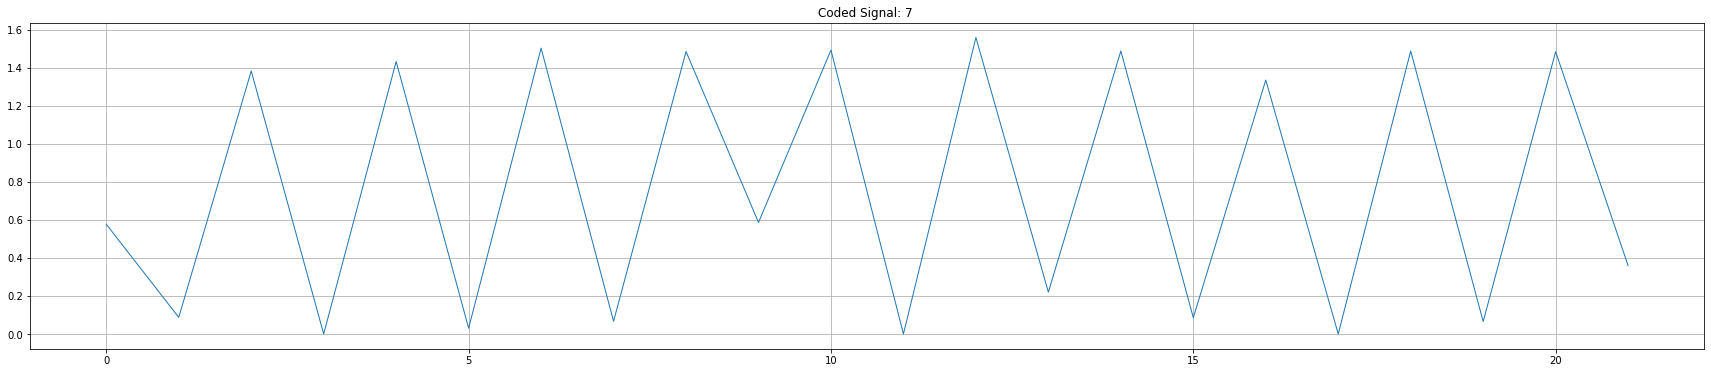

Reconstructed signal:  7


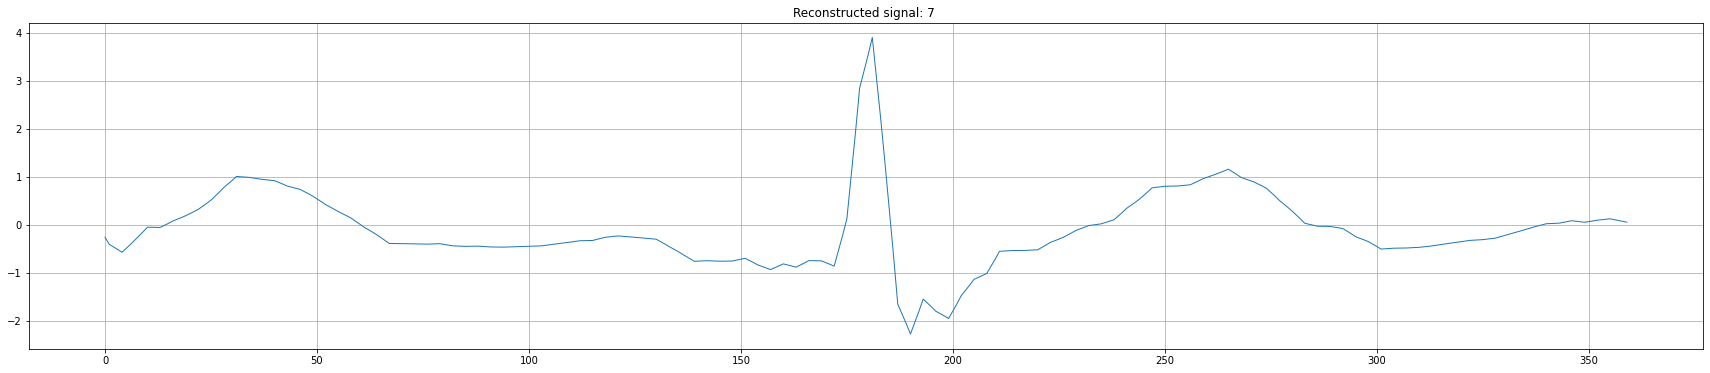

Original signal:  8


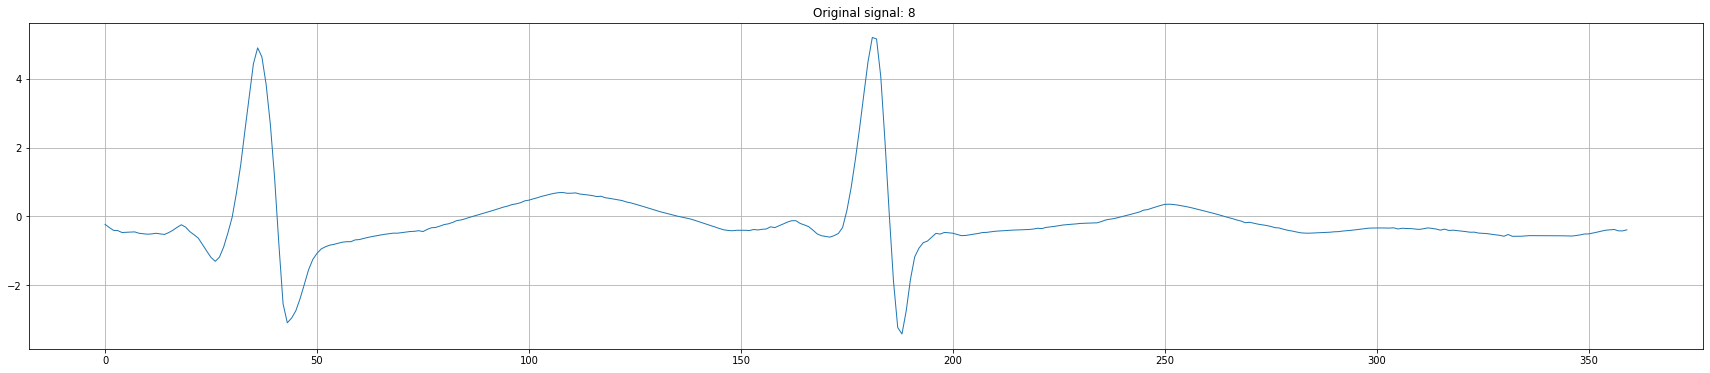

Encoded signal:  8


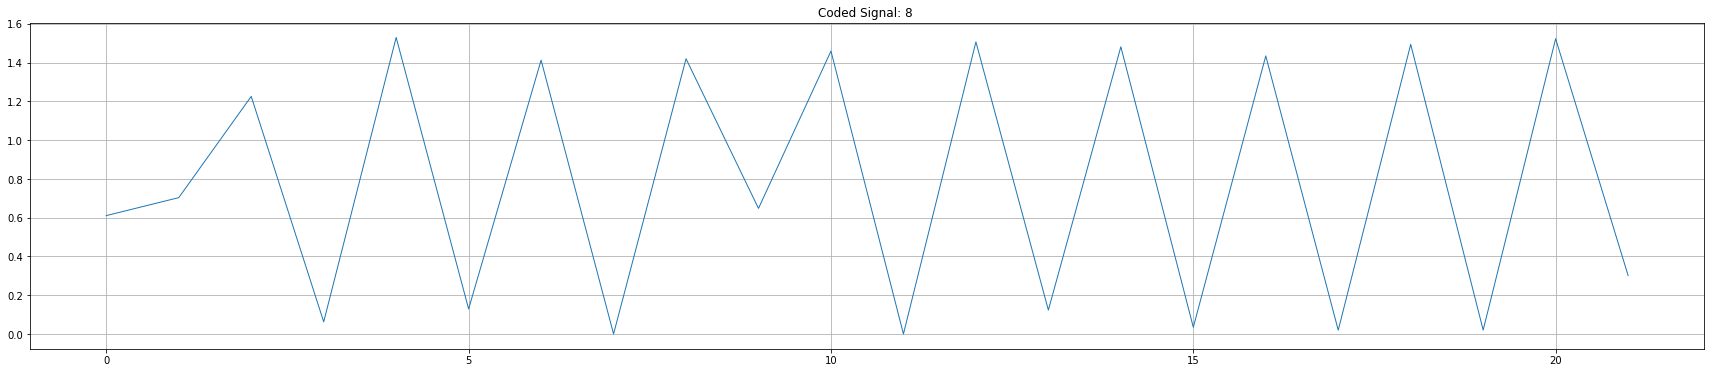

Reconstructed signal:  8


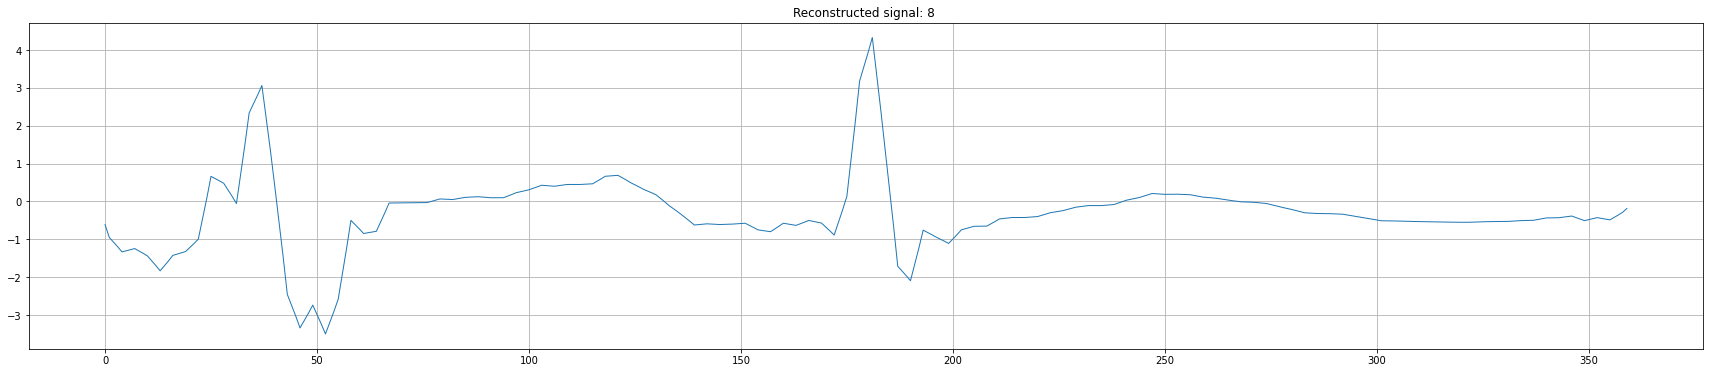

Original signal:  9


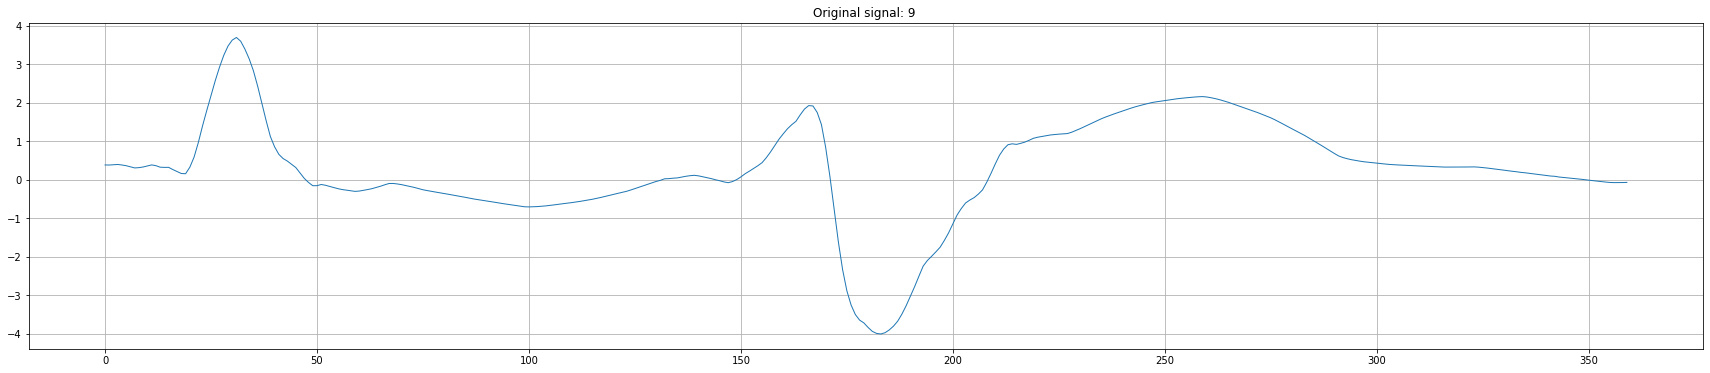

Encoded signal:  9


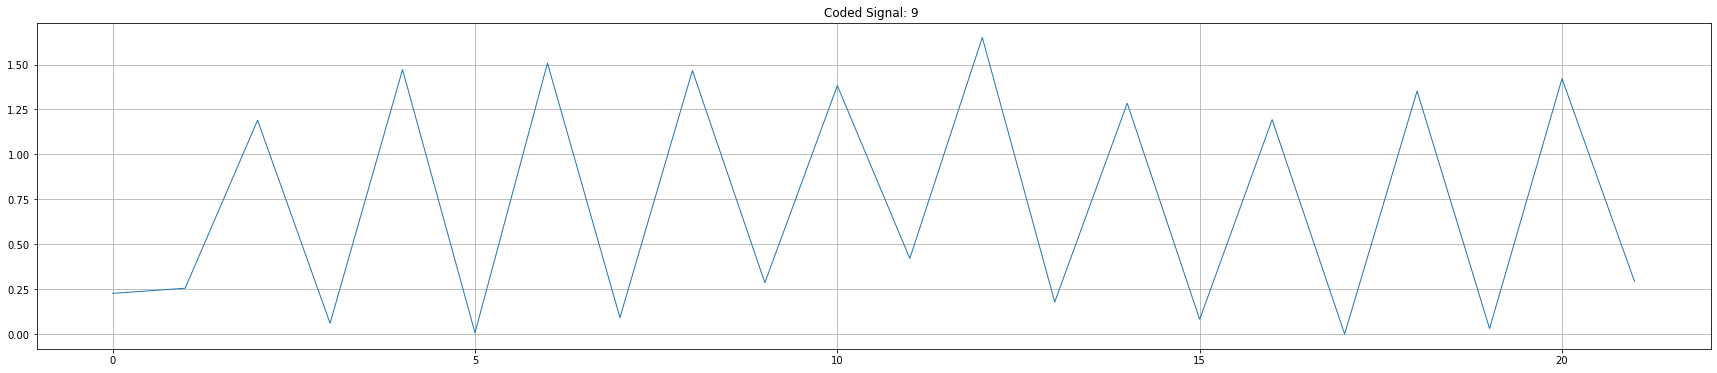

Reconstructed signal:  9


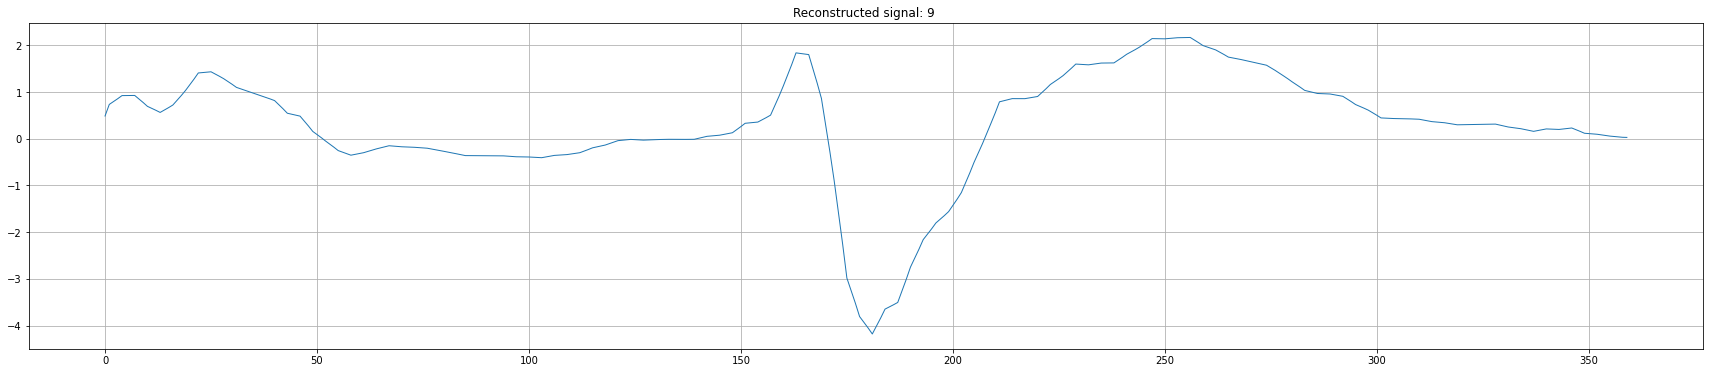

In [50]:
for i in range(10):
    print("Original signal: ",i)
    plt.plot(test_x[i])
    plt.title(f"Original signal: %d " % i)
    plt.show()
    print("Encoded signal: ",i)
    plt.plot(encoded_beat[i])
    plt.title(f"Coded Signal: %d " % i)
    plt.show()
    print("Reconstructed signal: ",i)
    plt.plot(reconstructed_beats[i])
    plt.title(f"Reconstructed signal: %d " % i)
    plt.show()

In [42]:
def quality_score(cr, prd):
    return cr/prd

In [43]:
print(quality_score(cr,prd*10))

9.322496435404208
